In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp
import qvalue as qv

In [2]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)

In [4]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [5]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import qvalue as qv

clusterframes = {}

receptors = ['ER Status', 'PR Status', 'HER2 Status', 'Triple Neg']
for i in receptors:
    if type(i) == str:
        df_cluster = pd.DataFrame(index=pca_per_pathway.columns) 
        pvaluelist = []
        for pathway in df_cluster.index:
            results = ols("Q(pathway) ~ C(Q(i))", data=full_df).fit()
            table = sm.stats.anova_lm(results, typ=2)
            pvalue = table['PR(>F)'][0]
            pvaluelist.append(pvalue)
    
        df_cluster['p-values'] = pvaluelist
        qv.qvalues(df_cluster, 'p-values', 'qvalues')
        print(i)
        clusterframes[i] = df_cluster

ER Status
PR Status
HER2 Status
Triple Neg


In [6]:
clusterframes['ER Status']

,p-values,qvalues
RUNX1 regulates estrogen receptor mediated transcription,0.000000e+00,0.000000e+00
Transcriptional Regulation by MECP2,0.000000e+00,0.000000e+00
SLC-mediated transmembrane transport,0.000000e+00,0.000000e+00
Cyclin D associated events in G1,3.822443e-305,1.585604e-302
G1 Phase,3.822574e-305,1.585604e-302
...,...,...
PI-3K cascade:FGFR4,9.769136e-01,9.788014e-01
CLEC7A/inflammasome pathway,9.775655e-01,9.789815e-01
Defective MTR causes methylmalonic aciduria and homocystinuria type cblG,9.883994e-01,9.888798e-01
Defective MTRR causes methylmalonic aciduria and homocystinuria type cblE,9.884030e-01,9.888798e-01


In [23]:
significant_pathways = {}
def failures_of_null(cluster, my_xa, my_xb, iterations=10000):
    pvalues = clusterframes[cluster]['p-values'].tolist()
    pvalues = [1e-320 if x == 0.0 else x for x in pvalues]##p = 0 gives error so setting it to 1e-320
    pvalues = [0.999 if x == 1.0 else x for x in pvalues] ##pathways with p-val 1 gave error as range would be to inf
    pvalues = sorted(pvalues)
    z_scores = norm.ppf(pvalues)
    print(z_scores)
    xa = np.percentile(z_scores, my_xa)
    xb = np.percentile(z_scores, my_xb)
    print(f'Quantiles calculated: {xa}, {xb}')


    trunc_z = z_scores[z_scores>xa]
    trunc_z = trunc_z[trunc_z<xb]

    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)

    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    loc_guess = np.median(z_scores)
    scale_guess = np.std(z_scores)
    a_guess = (xa - loc_guess)/scale_guess
    b_guess = (xb - loc_guess)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=iterations)
    print(par)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.hist(z_scores, bins=50, density=True)
    ax.plot(z_scores, truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3]), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')
    ax.plot(z_scores, norm.pdf(z_scores, par[2], par[3]), 'g-', lw=5, alpha=0.6, label='norm pdf')
    ax.plot(z_scores, norm.sf(abs(z_scores-par[2]), 0, par[3]), 'y-', lw=5, alpha=0.6, label='norm sf')
    ax.legend(loc='best')
    plt.show()

    p_vals = norm.sf(abs(z_scores-par[2]), 0, par[3])

    plt.figure(figsize=(15, 10))
    plt.hist(p_vals, bins=30, density=True)
    plt.show()
    #print(pvalues[:10])
    print(p_vals[:20])
    sig_pathways = p_vals[p_vals < 0.001].size
    significant_pathways[cluster] = sig_pathways
    print(f'number of pathways with p < 0.001: {p_vals[p_vals < 0.001].size}')
    
    
    ##let's add to clusterframes
    clusterframes[cluster]['adjusted p-value'] = p_vals
    qv.qvalues(clusterframes[cluster], 'adjusted p-value', 'adjusted q-values')
    
    ##and log fold change
    clusterframes[cluster]['log adjusted p-value'] = -np.log10(clusterframes[cluster]['adjusted p-value'])
    clusterframes[cluster][f'cluster {cluster} log adjusted q-value'] = -np.log10(clusterframes[cluster]['adjusted q-values'])

[-38.26912534 -38.26912534 -38.26912534 ...   2.27010629   2.27022522
   2.95257308]
Quantiles calculated: -15.273574327698768, 2.811122370817394
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4438.01597989175
            Iterations: 16
            Function evaluations: 106
            Gradient evaluations: 16
[-1.31239078  1.50234927 -6.84146737  6.42499711]


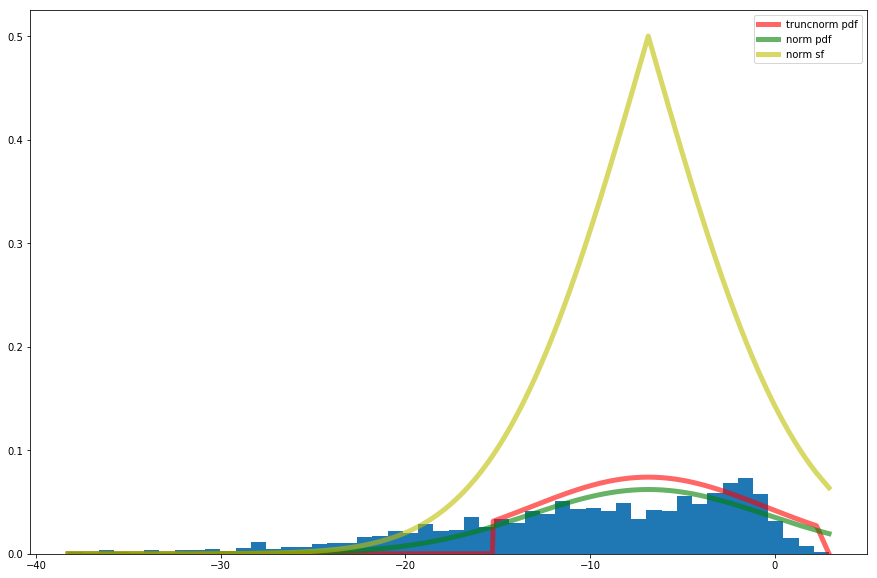

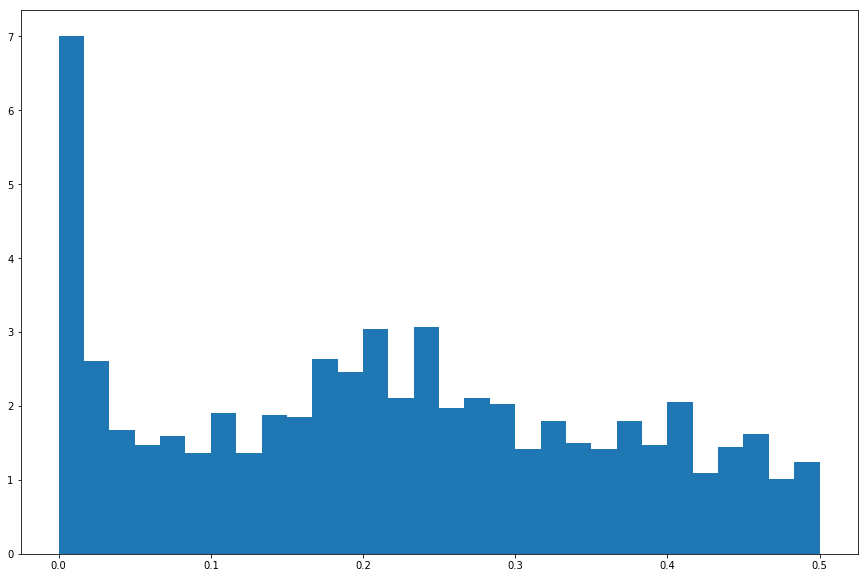

[5.00437224e-07 5.00437224e-07 5.00437224e-07 1.04865610e-06
 1.04865684e-06 1.85544863e-06 2.07380857e-06 2.51390747e-06
 2.66979268e-06 2.79176061e-06 3.20410680e-06 3.52739911e-06
 4.96940960e-06 5.71155219e-06 6.62240139e-06 9.39618055e-06
 1.19013064e-05 1.19750613e-05 1.40579991e-05 1.41347087e-05]
number of pathways with p < 0.001: 87


In [25]:
failures_of_null('ER Status', 25, 99.99)

[-28.90220919 -26.9032909  -23.64965628 ...   2.10681018   2.11164964
   2.90697512]
Quantiles calculated: -4.6108104692527245, 1.5516926755501301
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1417.39131737675
            Iterations: 1618
            Function evaluations: 13623
            Gradient evaluations: 1618
[-1.45388188  1.77388015 -1.83503221  1.90921855]


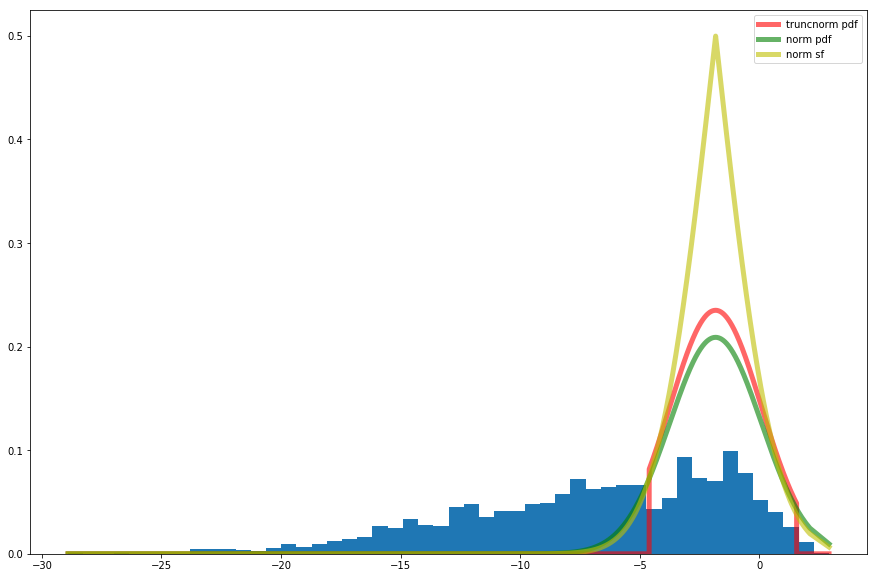

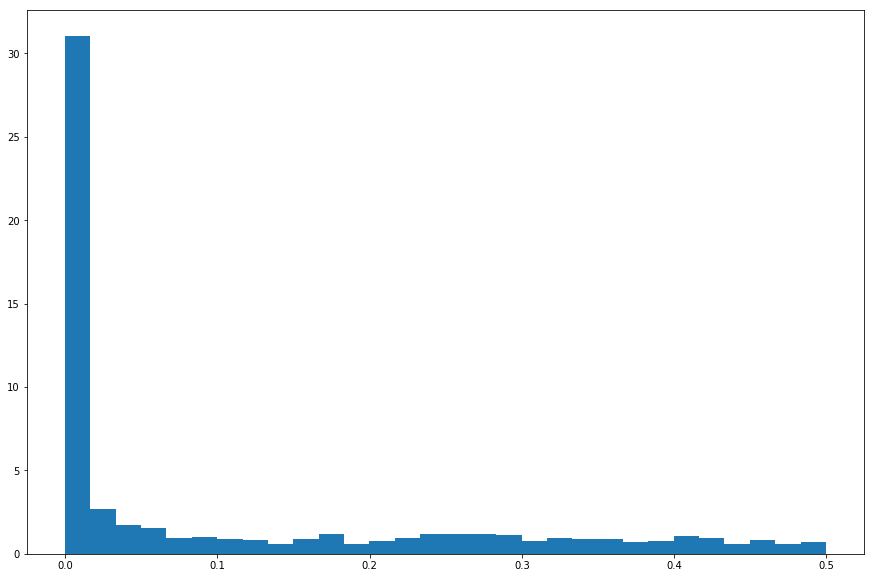

[6.34958760e-46 1.10660376e-39 1.55132892e-30 2.27152518e-30
 2.27156641e-30 2.81300597e-30 8.40755786e-30 1.58266660e-29
 2.26419582e-28 2.26444154e-28 2.46341440e-28 2.77026045e-28
 3.79186157e-28 4.94123898e-28 1.27679567e-27 1.85694704e-27
 2.48868494e-27 2.96107912e-27 3.40279867e-27 2.87453287e-26]
number of pathways with p < 0.001: 811


In [30]:
failures_of_null('PR Status', 60, 99)

[-21.16287283 -21.00340297 -18.10705278 ...   2.38382655   2.42612614
   3.11935131]
Quantiles calculated: -5.249682585901047, 2.975645734029999
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3204.4125198328275
            Iterations: 88
            Function evaluations: 680
            Gradient evaluations: 88
[-1.63617503  2.50507685 -1.99992207  1.98619368]


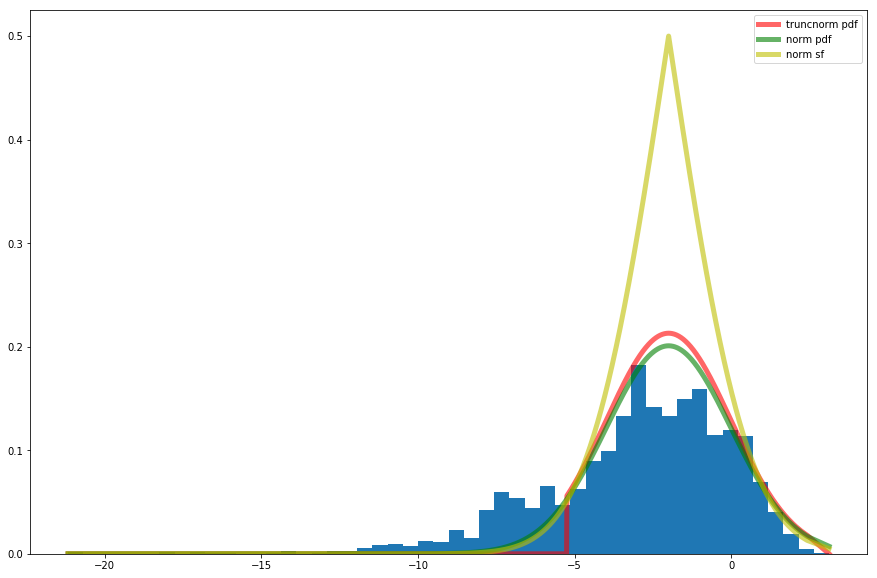

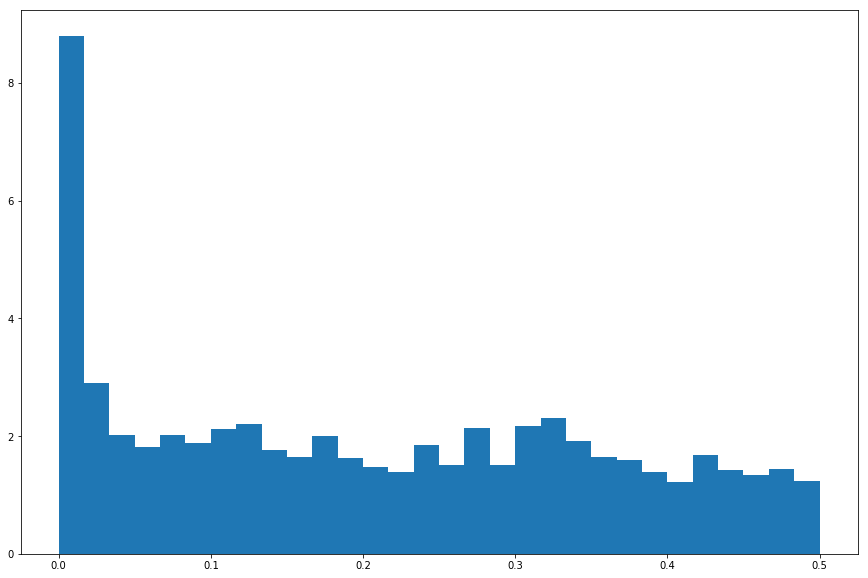

[2.50429078e-22 5.46084334e-22 2.54044418e-16 7.08013943e-16
 1.27309639e-14 3.14127092e-14 1.25500479e-13 4.09161258e-13
 1.48862832e-10 2.56547192e-10 8.62011438e-10 9.61213908e-10
 1.91932147e-08 2.82862109e-08 3.96582554e-08 5.32477982e-08
 1.32527865e-07 1.99563677e-07 2.66027679e-07 4.04964239e-07]
number of pathways with p < 0.001: 111


In [16]:
failures_of_null('HER2 Status', 20, 99.99)

[-37.47293133 -35.09328675 -34.55835369 ...   2.10102206   2.71782559
   2.83164732]
Quantiles calculated: -7.301652100708399, 2.808052078152175
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2039.1471530017716
            Iterations: 160
            Function evaluations: 1236
            Gradient evaluations: 160
[-1.23767046  2.22791965 -3.691161    2.91716673]


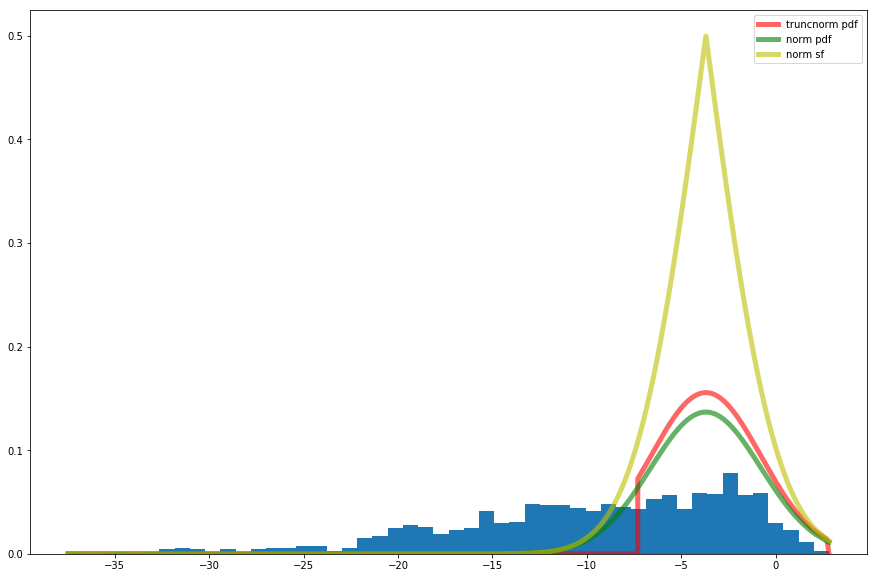

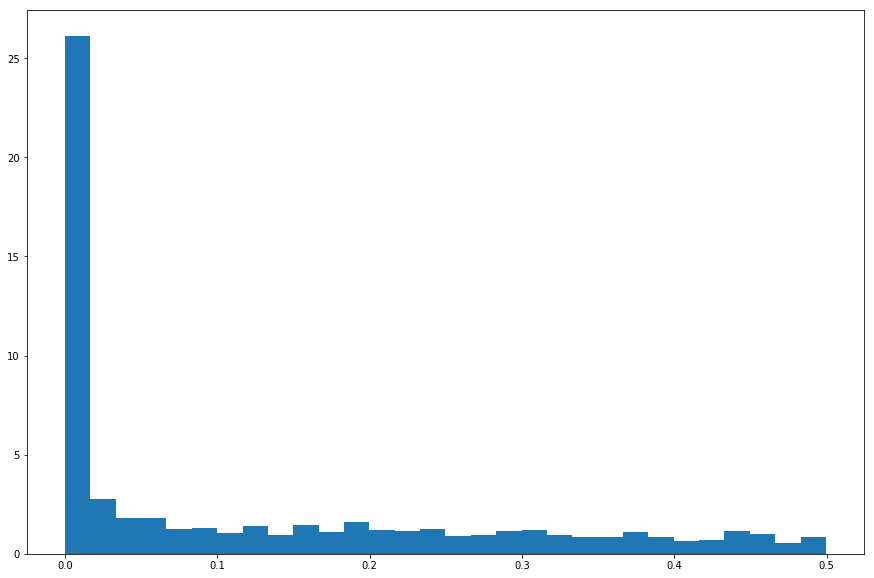

[2.59212887e-31 2.52910422e-27 1.82085972e-26 3.94331518e-26
 3.94334040e-26 3.86580490e-25 1.03298909e-24 7.71381481e-24
 1.62287996e-23 2.41544695e-23 4.46585346e-23 4.95058667e-23
 8.50567428e-23 1.10656636e-22 1.29635912e-22 1.44437968e-22
 2.99788596e-22 3.72681918e-22 4.37550759e-22 5.13108572e-22]
number of pathways with p < 0.001: 638


In [18]:
failures_of_null('Triple Neg', 55, 99.99)